# Gradient Mechanics: Batch Size 1 Analysis

**Clean gradient analysis with no batch averaging.**

With batch_size=1, each training step processes ONE token prediction:
- The model predicts token X
- The correct token is Y
- Token Y gets pushed toward the hidden state h
- Token X gets pushed away from h
- All other tokens get small updates

This eliminates batch averaging confusion and lets us trace individual token dynamics step by step.

## Key Questions

1. **Dimensionality:** Are gradients confined to 1D (parallel/antiparallel) or do they span higher dimensions?
2. **Evolution:** Does gradient space expand from 1D → 2D → 3D as training progresses?
3. **Crystals:** Can we see tokens moving together (uniform) or diffusing apart (thermal)?

## Parameters

In [17]:
# Paths
TRAINING_DATA_PATH = '../tensors/Lil_Gatsby/1.9c_training_data.safetensors'
CORPUS_PATH = '../data/the_great_gatsby.txt'

# Analysis
STEPS_TO_ANALYZE = [1, 2, 3, 4, 5, 6]  # Which training steps to examine

# Visualization
DPI = 200
COLORMAP = 'inferno'
RANDOM_SEED = 42

## Imports

In [18]:
import torch
import numpy as np
from safetensors.torch import load_file
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## Device Detection

In [19]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f'Using device: {device}')

Using device: mps


## Load Training Data

In [20]:
# Load training data
data = load_file(TRAINING_DATA_PATH)

grads = data['grads']  # (1001, 128, 64)
embeddings = data['embeddings']  # (1001, 128, 64)
logits = data['logits']  # (1001, 128)
dead_token_ids = data['dead_token_ids'].cpu().numpy()
live_token_ids = data['live_token_ids'].cpu().numpy()

print('Loaded training data:')
print(f'  Gradients: {grads.shape}')
print(f'  Embeddings: {embeddings.shape}')
print(f'  Logits: {logits.shape}')
print(f'  Steps: {grads.shape[0] - 1} (plus initial state)')
print()
print(f'  Dead tokens: {len(dead_token_ids)}')
print(f'  Live tokens: {len(live_token_ids)}')

Loaded training data:
  Gradients: torch.Size([1001, 128, 64])
  Embeddings: torch.Size([1001, 128, 64])
  Logits: torch.Size([1001, 128])
  Steps: 1000 (plus initial state)

  Dead tokens: 50
  Live tokens: 78


## Load Corpus (to decode predictions)

In [21]:
# Load corpus as bytes
with open(CORPUS_PATH, 'rb') as f:
    corpus_bytes = f.read()

print(f'Loaded corpus: {len(corpus_bytes):,} bytes')
print(f'First 100 chars: {repr(corpus_bytes[:100].decode("ascii"))}')

Loaded corpus: 272,305 bytes
First 100 chars: 'The Great Gatsby\r\n                                  by\r\n                          F. Scott Fitzgeral'


## Helper Functions

In [22]:
def analyze_step(step_num):
    """Analyze gradient structure at a specific training step."""
    
    # Get gradients for this step
    step_grads = grads[step_num].cpu().numpy()  # (128, 64)
    
    # Compute magnitudes
    mags = np.linalg.norm(step_grads, axis=1)
    
    # Normalize for cosine similarity
    step_grads_norm = step_grads / (mags[:, None] + 1e-10)
    
    # Compute pairwise cosine similarities
    cosine_matrix = step_grads_norm @ step_grads_norm.T
    
    # Extract upper triangle
    triu_idx = np.triu_indices(128, k=1)
    cosines = cosine_matrix[triu_idx]
    
    # Find which token was predicted (highest logit)
    predicted_token = np.argmax(logits[step_num].cpu().numpy())
    
    # Find correct token (from corpus)
    if step_num > 0 and step_num <= len(corpus_bytes):
        correct_token = corpus_bytes[step_num - 1]
    else:
        correct_token = None
    
    return {
        'step': step_num,
        'grads': step_grads,
        'mags': mags,
        'cosines': cosines,
        'cosine_matrix': cosine_matrix,
        'predicted': predicted_token,
        'correct': correct_token
    }

print('✓ Helper functions defined')

✓ Helper functions defined


## Analyze Selected Steps

In [23]:
print('='*70)
print('GRADIENT DIMENSIONALITY ACROSS TRAINING')
print('='*70)
print()

results = []

for step in STEPS_TO_ANALYZE:
    if step >= grads.shape[0]:
        print(f'⚠ Step {step} exceeds available data')
        continue
    
    result = analyze_step(step)
    results.append(result)
    
    cosines = result['cosines']
    predicted = result['predicted']
    correct = result['correct']
    
    print(f"Step {step}:")
    
    # Show prediction context
    if correct is not None:
        pred_char = chr(predicted) if 32 <= predicted < 127 else repr(chr(predicted))
        correct_char = chr(correct) if 32 <= correct < 127 else repr(chr(correct))
        match = '✓' if predicted == correct else '✗'
        print(f"  Prediction: {match} predicted |{pred_char}| (ASCII {predicted}), correct was |{correct_char}| (ASCII {correct})")
    
    # Cosine similarity stats
    print(f"  Cosine similarities:")
    print(f"    Min: {cosines.min():.6f}")
    print(f"    Max: {cosines.max():.6f}")
    print(f"    Mean: {cosines.mean():.6f}")
    print(f"    Median: {np.median(cosines):.6f}")
    print(f"    Std: {cosines.std():.6f}")
    
    # Check for bimodal distribution (parallel/antiparallel)
    near_parallel = np.sum(cosines > 0.95)
    near_antiparallel = np.sum(cosines < -0.95)
    near_orthogonal = np.sum(np.abs(cosines) < 0.1)
    
    total_pairs = len(cosines)
    print(f"  Distribution:")
    print(f"    Near parallel (>0.95): {near_parallel}/{total_pairs} ({100*near_parallel/total_pairs:.1f}%)")
    print(f"    Near antiparallel (<-0.95): {near_antiparallel}/{total_pairs} ({100*near_antiparallel/total_pairs:.1f}%)")
    print(f"    Near orthogonal (|cos|<0.1): {near_orthogonal}/{total_pairs} ({100*near_orthogonal/total_pairs:.1f}%)")
    
    print()

print('='*70)

GRADIENT DIMENSIONALITY ACROSS TRAINING

Step 1:
  Prediction: ✗ predicted |'\x00'| (ASCII 0), correct was |T| (ASCII 84)
  Cosine similarities:
    Min: -0.999501
    Max: 1.000000
    Mean: 0.356861
    Median: 1.000000
    Std: 0.888969
  Distribution:
    Near parallel (>0.95): 5202/8128 (64.0%)
    Near antiparallel (<-0.95): 2300/8128 (28.3%)
    Near orthogonal (|cos|<0.1): 618/8128 (7.6%)

Step 2:
  Prediction: ✗ predicted |'\n'| (ASCII 10), correct was |h| (ASCII 104)
  Cosine similarities:
    Min: -0.999685
    Max: 1.000000
    Mean: 0.463037
    Median: 1.000000
    Std: 0.839617
  Distribution:
    Near parallel (>0.95): 5509/8128 (67.8%)
    Near antiparallel (<-0.95): 1872/8128 (23.0%)
    Near orthogonal (|cos|<0.1): 6/8128 (0.1%)

Step 3:
  Prediction: ✗ predicted |'\n'| (ASCII 10), correct was |e| (ASCII 101)
  Cosine similarities:
    Min: -0.999661
    Max: 1.000000
    Mean: 0.443192
    Median: 0.999999
    Std: 0.852813
  Distribution:
    Near parallel (>0.95):

## Visualize Cosine Distribution Evolution

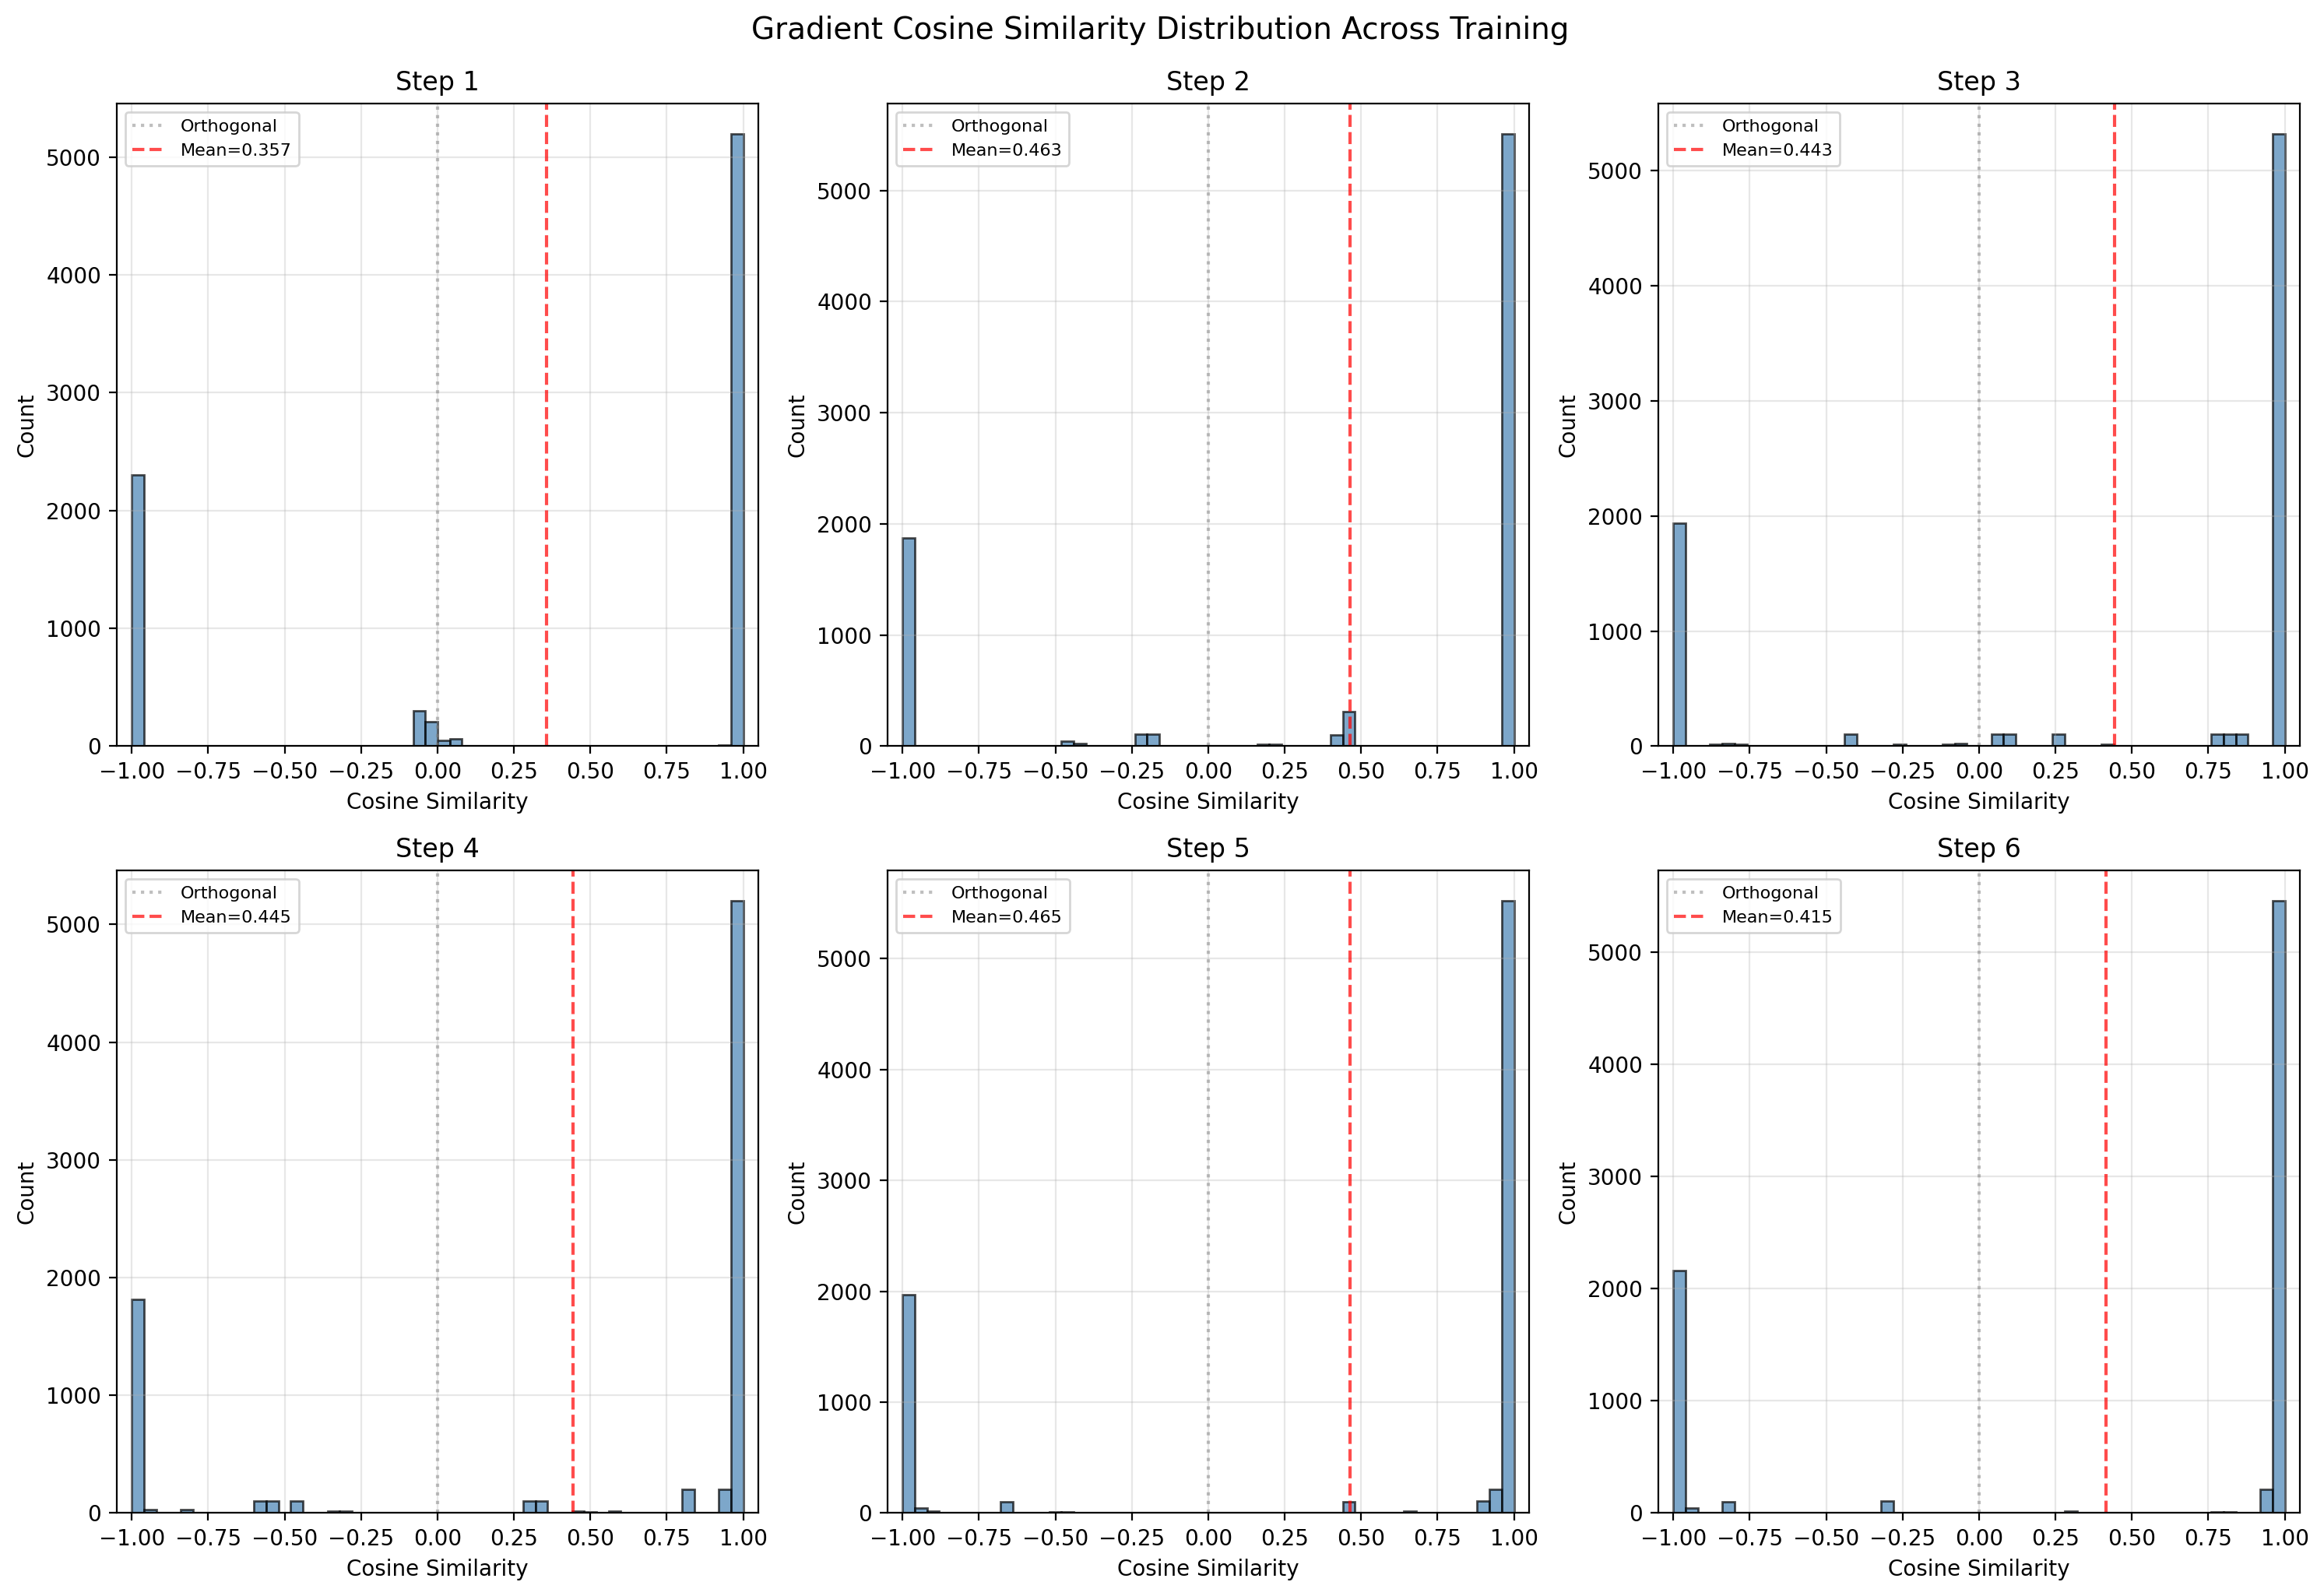

In [24]:
n_steps = len(results)
fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=DPI)
axes = axes.flatten()

for i, result in enumerate(results):
    ax = axes[i]
    cosines = result['cosines']
    step = result['step']
    
    ax.hist(cosines, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    ax.axvline(0, color='gray', linestyle=':', alpha=0.5, label='Orthogonal')
    ax.axvline(cosines.mean(), color='red', linestyle='--', alpha=0.7, label=f'Mean={cosines.mean():.3f}')
    ax.set_xlabel('Cosine Similarity')
    ax.set_ylabel('Count')
    ax.set_title(f'Step {step}')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)
    ax.set_xlim(-1.05, 1.05)

# Hide unused subplots
for i in range(len(results), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Gradient Cosine Similarity Distribution Across Training', y=1.02, fontsize=14)
plt.show()

## PCA Analysis: Effective Dimensionality

In [25]:
print('='*70)
print('PCA: EFFECTIVE GRADIENT DIMENSIONALITY')
print('='*70)
print()

for result in results:
    step = result['step']
    step_grads = result['grads']
    
    # Perform PCA
    pca = PCA(n_components=10)
    pca.fit(step_grads)
    
    explained = pca.explained_variance_ratio_
    cumulative = np.cumsum(explained)
    
    print(f"Step {step}:")
    print(f"  PC1: {explained[0]:.4f} ({cumulative[0]:.4f} cumulative)")
    print(f"  PC2: {explained[1]:.4f} ({cumulative[1]:.4f} cumulative)")
    print(f"  PC3: {explained[2]:.4f} ({cumulative[2]:.4f} cumulative)")
    print(f"  PC1-5 cumulative: {cumulative[4]:.4f}")
    print(f"  PC1-10 cumulative: {cumulative[9]:.4f}")
    
    # Effective dimensionality (90% variance)
    n_dims_90 = np.argmax(cumulative >= 0.90) + 1
    print(f"  Effective dims (90% variance): {n_dims_90}")
    
    print()

print('='*70)

PCA: EFFECTIVE GRADIENT DIMENSIONALITY

Step 1:
  PC1: 0.9967 (0.9967 cumulative)
  PC2: 0.0005 (0.9973 cumulative)
  PC3: 0.0003 (0.9976 cumulative)
  PC1-5 cumulative: 0.9981
  PC1-10 cumulative: 0.9990
  Effective dims (90% variance): 1

Step 2:
  PC1: 0.9981 (0.9981 cumulative)
  PC2: 0.0003 (0.9984 cumulative)
  PC3: 0.0002 (0.9986 cumulative)
  PC1-5 cumulative: 0.9990
  PC1-10 cumulative: 0.9996
  Effective dims (90% variance): 1

Step 3:
  PC1: 0.9986 (0.9986 cumulative)
  PC2: 0.0004 (0.9989 cumulative)
  PC3: 0.0002 (0.9991 cumulative)
  PC1-5 cumulative: 0.9993
  PC1-10 cumulative: 0.9997
  Effective dims (90% variance): 1

Step 4:
  PC1: 0.9986 (0.9986 cumulative)
  PC2: 0.0002 (0.9989 cumulative)
  PC3: 0.0002 (0.9990 cumulative)
  PC1-5 cumulative: 0.9993
  PC1-10 cumulative: 0.9997
  Effective dims (90% variance): 1

Step 5:
  PC1: 0.9989 (0.9989 cumulative)
  PC2: 0.0002 (0.9991 cumulative)
  PC3: 0.0001 (0.9992 cumulative)
  PC1-5 cumulative: 0.9994
  PC1-10 cumulative

## Visualize PCA Explained Variance

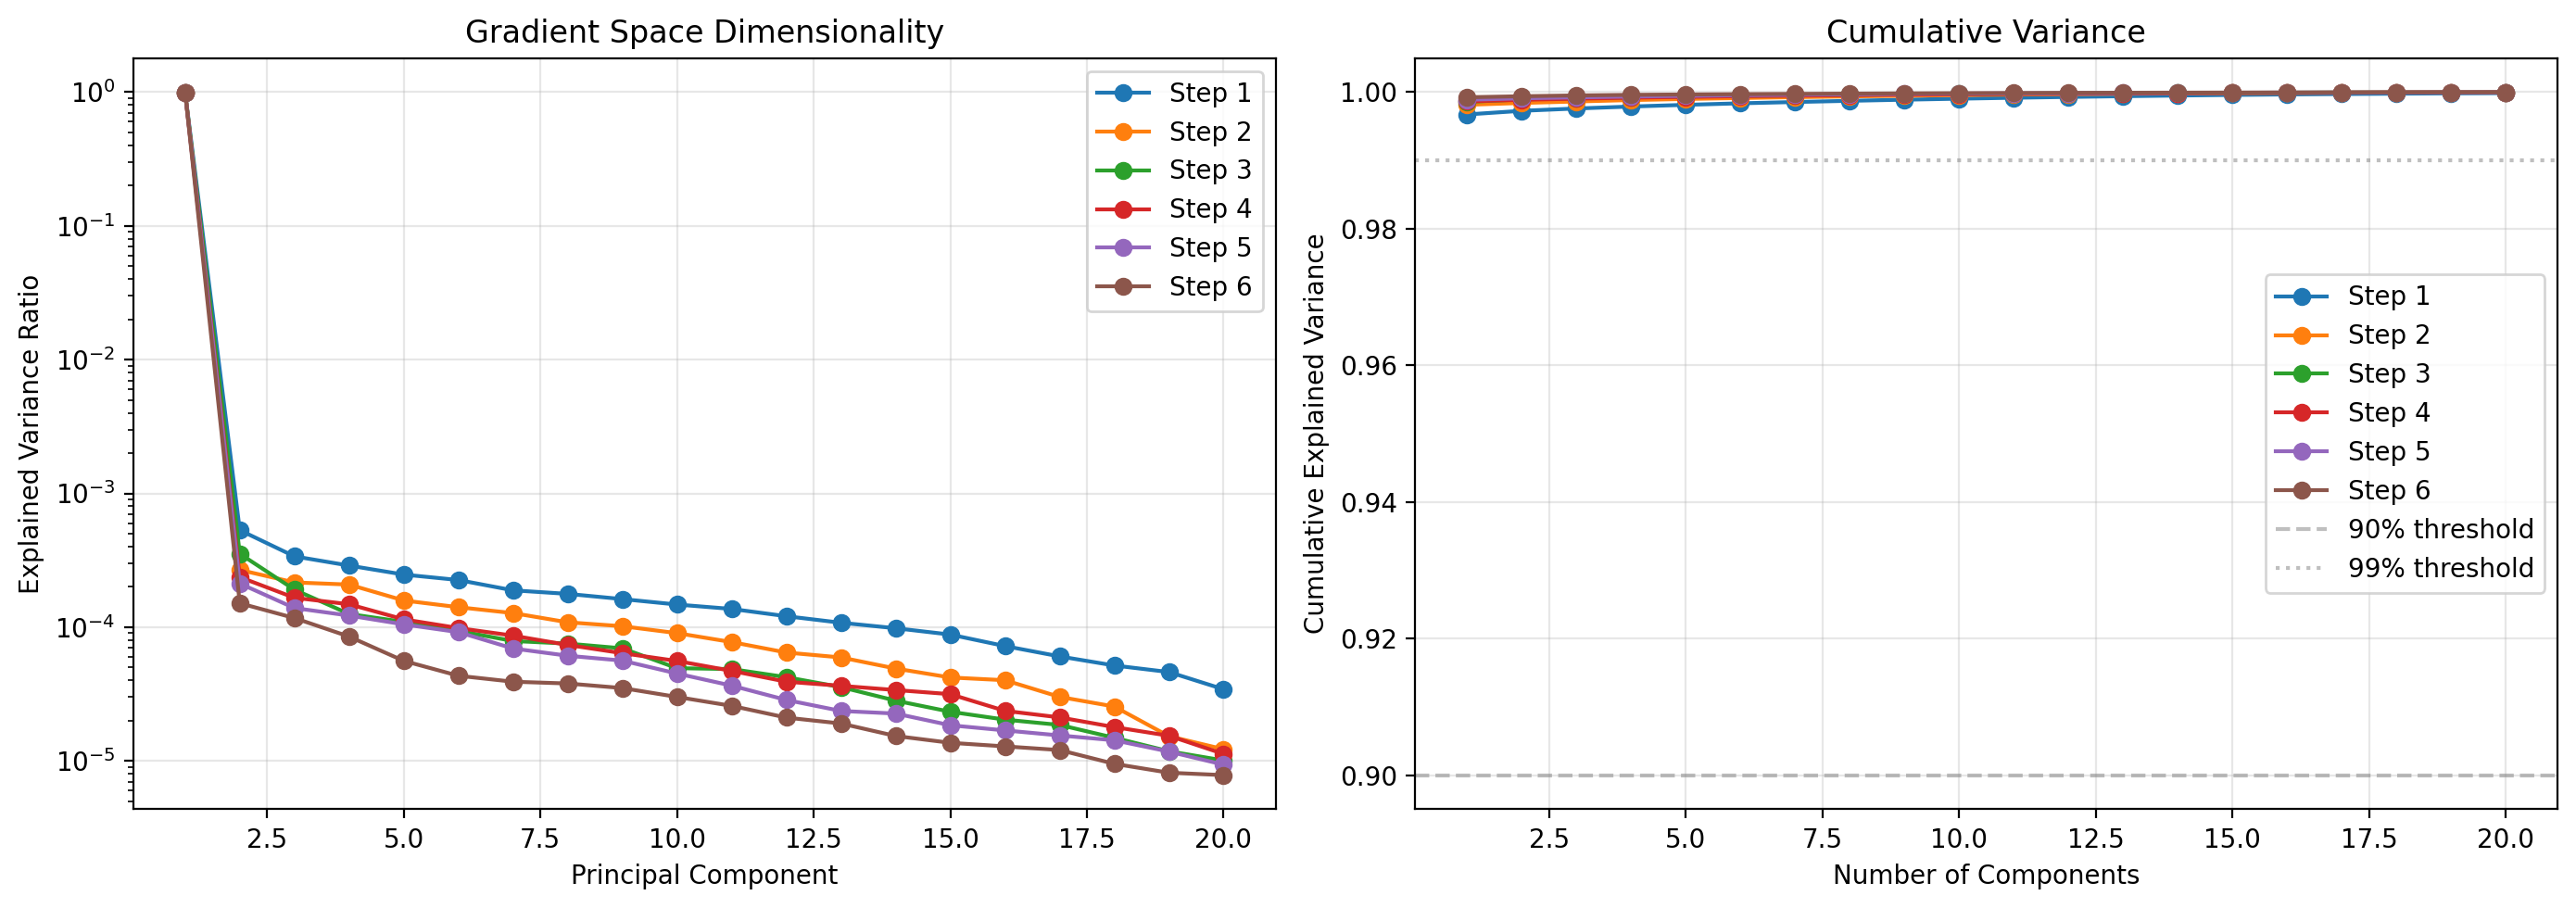

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=DPI)

# Left: Explained variance by PC
ax = axes[0]
for result in results:
    step = result['step']
    pca = PCA(n_components=20)
    pca.fit(result['grads'])
    ax.plot(range(1, 21), pca.explained_variance_ratio_, marker='o', label=f'Step {step}')

ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('Gradient Space Dimensionality')
ax.legend()
ax.grid(alpha=0.3)
ax.set_yscale('log')

# Right: Cumulative variance
ax = axes[1]
for result in results:
    step = result['step']
    pca = PCA(n_components=20)
    pca.fit(result['grads'])
    cumulative = np.cumsum(pca.explained_variance_ratio_)
    ax.plot(range(1, 21), cumulative, marker='o', label=f'Step {step}')

ax.axhline(0.9, color='gray', linestyle='--', alpha=0.5, label='90% threshold')
ax.axhline(0.99, color='gray', linestyle=':', alpha=0.5, label='99% threshold')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Cumulative Explained Variance')
ax.set_title('Cumulative Variance')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 2D Gradient Projections

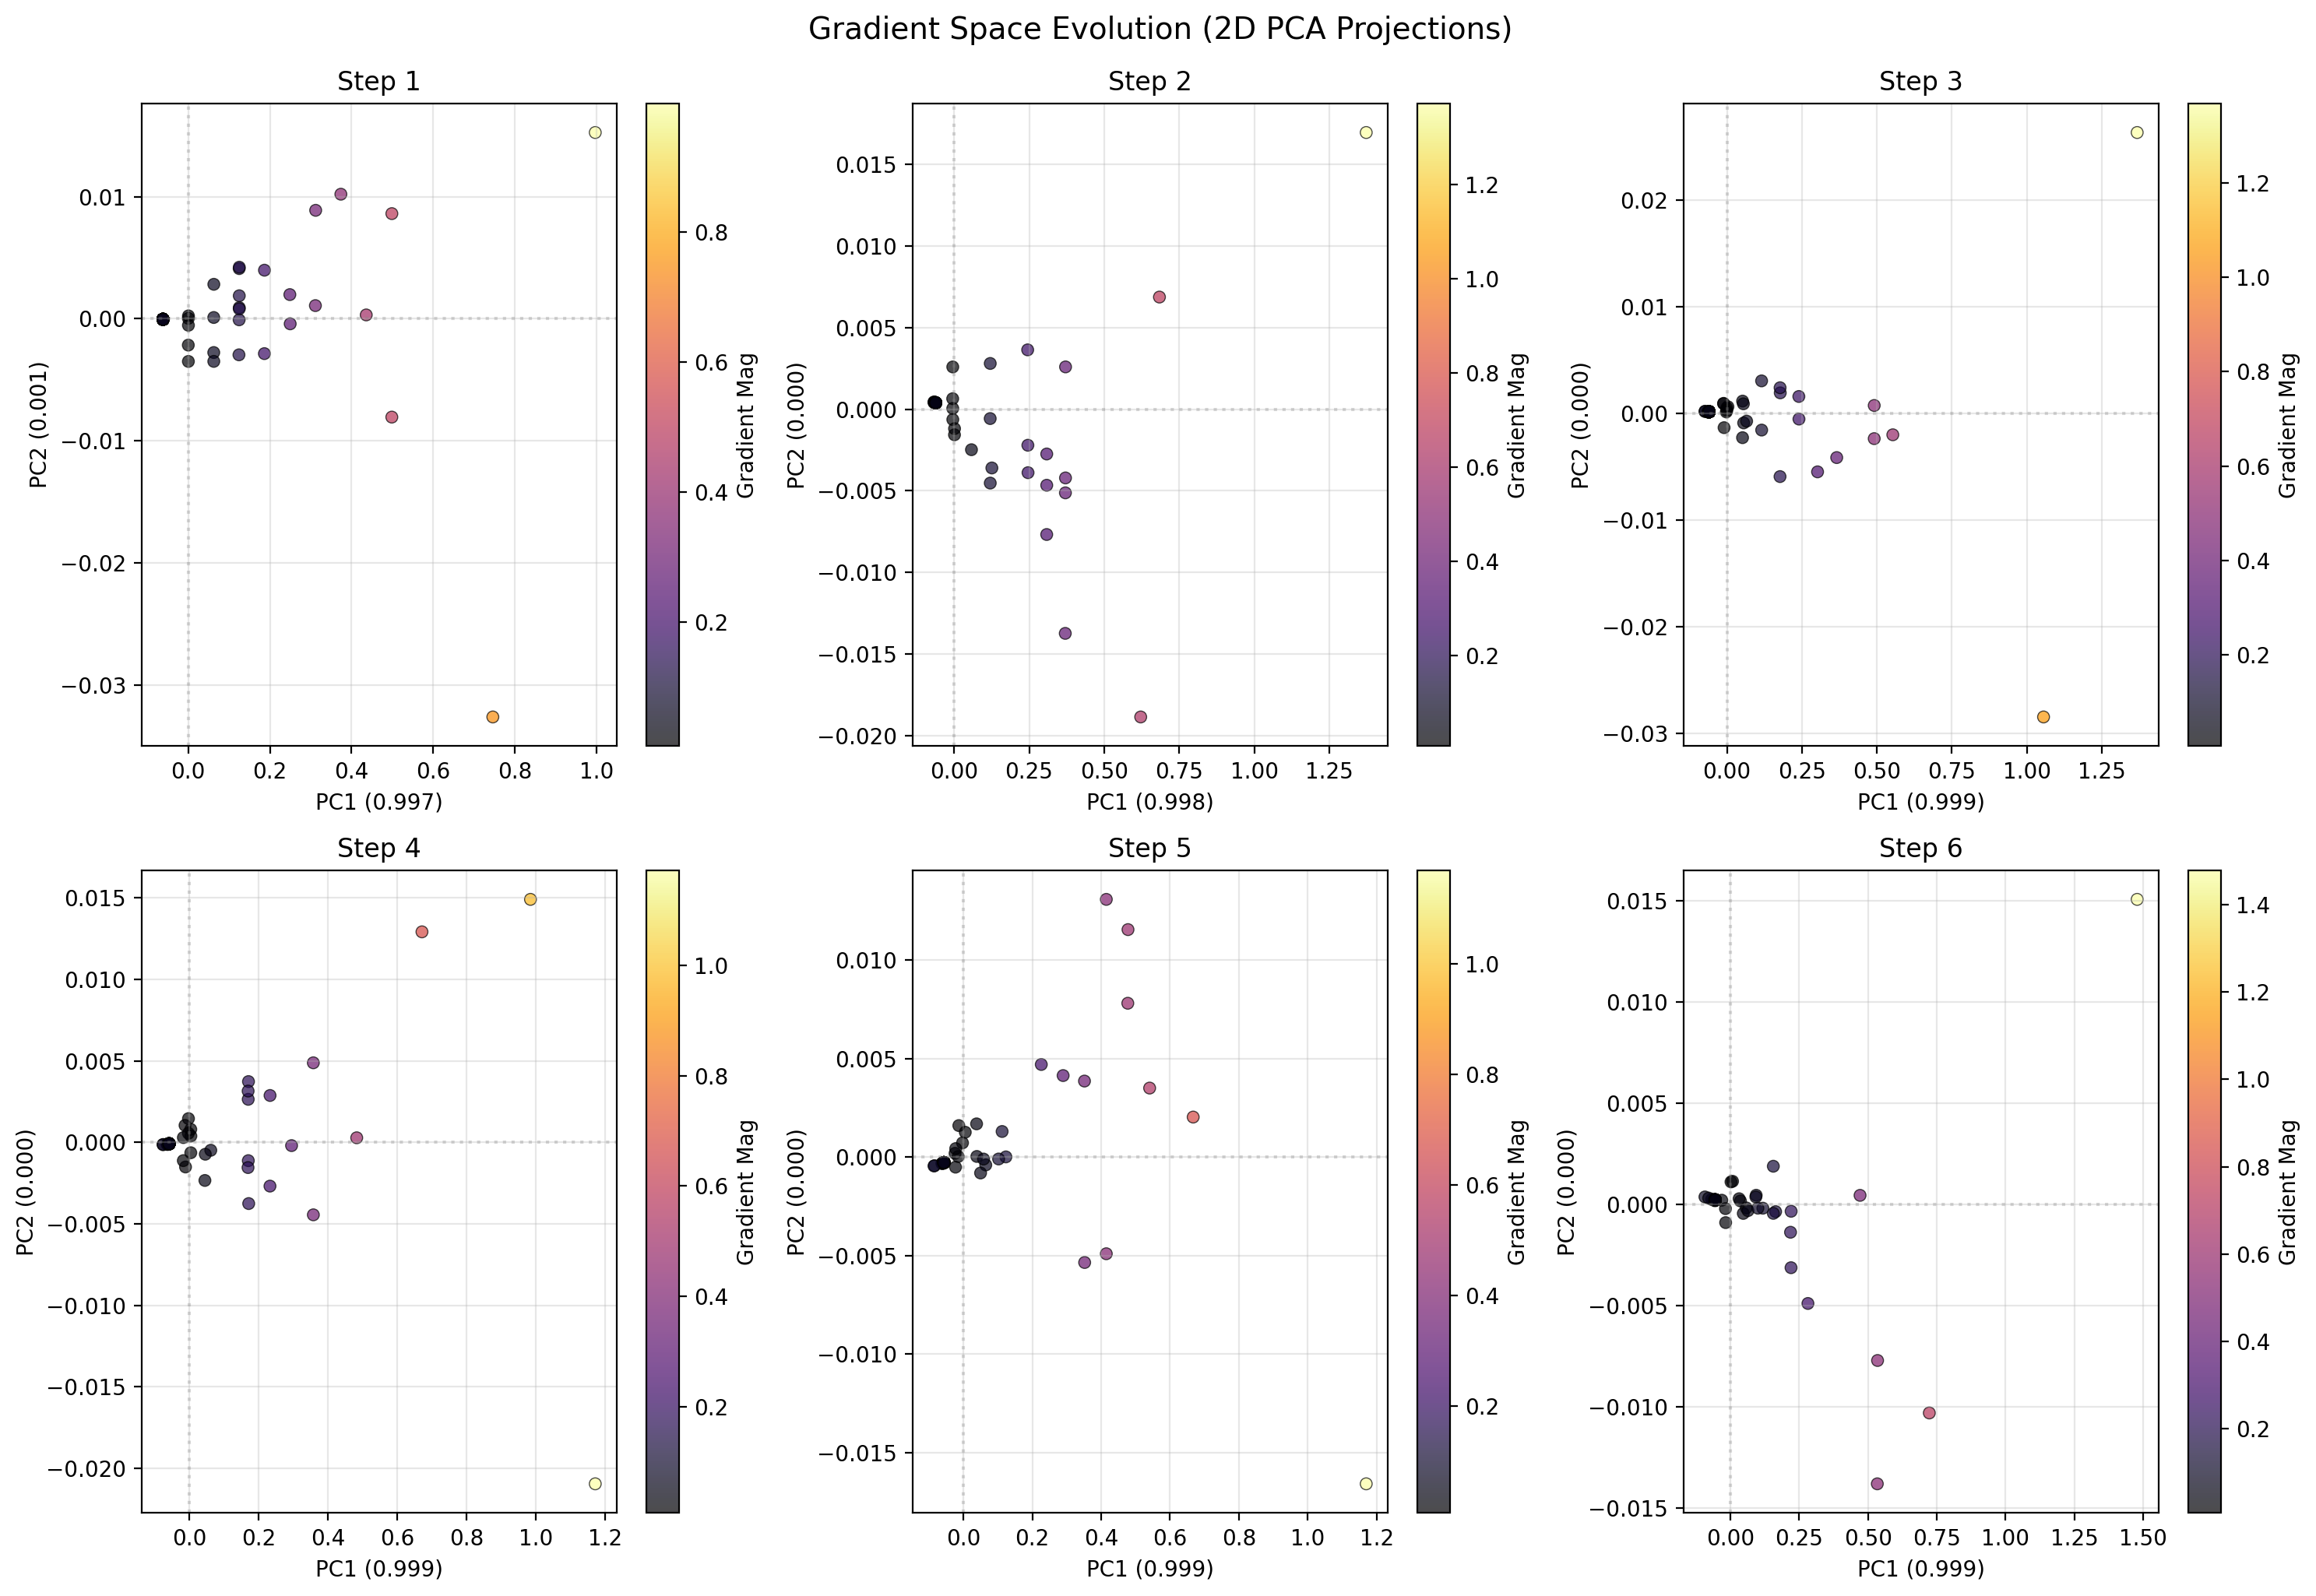

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=DPI)
axes = axes.flatten()

for i, result in enumerate(results):
    ax = axes[i]
    step = result['step']
    step_grads = result['grads']
    mags = result['mags']
    
    # Project to 2D
    pca = PCA(n_components=2, random_state=RANDOM_SEED)
    grads_2d = pca.fit_transform(step_grads)
    
    # Color by magnitude
    scatter = ax.scatter(grads_2d[:, 0], grads_2d[:, 1], c=mags, cmap=COLORMAP, 
                        s=30, alpha=0.7, edgecolors='black', linewidths=0.5)
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
    ax.set_title(f'Step {step}')
    ax.grid(alpha=0.3)
    ax.axhline(0, color='gray', linestyle=':', alpha=0.3)
    ax.axvline(0, color='gray', linestyle=':', alpha=0.3)
    
    plt.colorbar(scatter, ax=ax, label='Gradient Mag')

# Hide unused subplots
for i in range(len(results), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Gradient Space Evolution (2D PCA Projections)', y=1.02, fontsize=14)
plt.show()

## Summary

In [28]:
print('='*70)
print('SUMMARY: GRADIENT MECHANICS WITH BATCH_SIZE=1')
print('='*70)
print()
print('Key Findings:')
print()

# Check if early steps are 1D
early_result = results[0]
pca = PCA(n_components=10)
pca.fit(early_result['grads'])
early_pc1 = pca.explained_variance_ratio_[0]

if early_pc1 > 0.95:
    print('✓ EARLY TRAINING (Step 1):')
    print(f'  Gradients are essentially 1D (PC1 explains {early_pc1:.1%})')
    print('  All updates parallel/antiparallel to single direction')
else:
    print('⚠ EARLY TRAINING (Step 1):')
    print(f'  Gradients already span multiple dimensions (PC1={early_pc1:.1%})')

print()

# Check dimensionality evolution
late_result = results[-1]
pca = PCA(n_components=10)
pca.fit(late_result['grads'])
late_pc1 = pca.explained_variance_ratio_[0]
late_cumulative = np.cumsum(pca.explained_variance_ratio_)
late_dims_90 = np.argmax(late_cumulative >= 0.90) + 1

print(f'✓ LATE TRAINING (Step {late_result["step"]}):')
print(f'  PC1 explains {late_pc1:.1%}')
print(f'  Effective dimensionality (90% var): {late_dims_90}D')

if late_dims_90 > 1:
    print('  → Gradient space has expanded beyond 1D')
    print('  → This could enable diffusion/crystal dissolution')
else:
    print('  → Gradient space remains essentially 1D')
    print('  → Tokens should move together (no diffusion)')

print()
print('='*70)

SUMMARY: GRADIENT MECHANICS WITH BATCH_SIZE=1

Key Findings:

✓ EARLY TRAINING (Step 1):
  Gradients are essentially 1D (PC1 explains 99.7%)
  All updates parallel/antiparallel to single direction

✓ LATE TRAINING (Step 6):
  PC1 explains 99.9%
  Effective dimensionality (90% var): 1D
  → Gradient space remains essentially 1D
  → Tokens should move together (no diffusion)

